In [1]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim_models
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter
from sklearn import svm, datasets
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#Get the dataset and combine
test_df = pd.read_csv('/Users/ritaguan/Desktop/Constraint_Test.csv')
train_df = pd.read_csv('/Users/ritaguan/Desktop/Constraint_Train.csv')
val_df=pd.read_csv('/Users/ritaguan/Desktop/Constraint_Val.csv')
concat_df =  pd.concat([test_df, train_df, val_df])

#count the number of real and fake news (label)
print(val_df['label'].value_counts())
print(concat_df['label'].value_counts())

#find fake and real news 
combined = concat_df['tweet']
fake = concat_df[concat_df['label']=='fake']['tweet']
real = concat_df[concat_df['label']=='real']['tweet']

real    1120
fake    1020
Name: label, dtype: int64
real    4480
fake    4080
Name: label, dtype: int64


In [3]:
#Dataset Overview
test_df.head(3)

,id,tweet
0,1,Our daily update is published. States reported...
1,2,Alfalfa is the only cure for COVID-19.
2,3,President Trump Asked What He Would Do If He W...


In [61]:
#Dataset Basic Description
test_df.describe()

,id
count,2140.000000
mean,1070.500000
std,617.909109
min,1.000000
25%,535.750000
50%,1070.500000
75%,1605.250000
max,2140.000000


In [4]:
#Dataset Basic Description
train_df.describe()

,id
count,6420.000000
mean,3210.500000
std,1853.438696
min,1.000000
25%,1605.750000
50%,3210.500000
75%,4815.250000
max,6420.000000


In [5]:
#Dataset Basic Description
val_df.describe()

,id
count,2140.000000
mean,1070.500000
std,617.909109
min,1.000000
25%,535.750000
50%,1070.500000
75%,1605.250000
max,2140.000000


In [6]:
#Dataset Basic Description
concat_df.describe()

,id
count,10700.000000
mean,2354.500000
std,1820.133749
min,1.000000
25%,892.000000
50%,1784.000000
75%,3745.250000
max,6420.000000


In [7]:
# datasets ready to do the combine, fake, real tokenization
combined=concat_df['tweet'].to_numpy()
fake = concat_df[concat_df['label']=='fake']['tweet']
real = concat_df[concat_df['label']=='real']['tweet']

In [8]:
# tokenize the combined dataset
df_new_combined = pd.DataFrame(combined, columns = ['Orig'])

In [9]:
def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: give_emoji_free_text(x)

# Apply `call_emoji_free` which calls the function to remove all emoji's
df_new_combined['emoji_free_tweets'] = df_new_combined['Orig'].apply(call_emoji_free)

#Create a new column with url free tweets
df_new_combined['url_free_tweets'] = df_new_combined['emoji_free_tweets'].apply(url_free_text)

In [10]:
# Load spacy
# Make sure to restart the runtime after running installations and libraries tab
nlp = spacy.load('en_core_web_lg')

#nlp = en_core_web_lg.load()
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-','covid19','covid','19','got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df_new_combined['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df_new_combined['tokens'] = tokens

In [11]:
# Make tokens a string again
df_new_combined['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df_new_combined['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df_new_combined['lemmas'] = df_new_combined['tokens_back_to_text'].apply(get_lemmas)

In [12]:
# Make lemmas a string again
df_new_combined['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df_new_combined['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE
    tokens = re.sub('$', '', text)

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df_new_combined['lemma_tokens'] = df_new_combined['lemmas_back_to_text'].apply(tokenize)

<>:19: DeprecationWarning: invalid escape sequence \w
<>:20: DeprecationWarning: invalid escape sequence \$
<ipython-input-12-b1032d18b913>:19: DeprecationWarning: invalid escape sequence \w
  tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
<ipython-input-12-b1032d18b913>:20: DeprecationWarning: invalid escape sequence \$
  tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $


In [13]:
df_new_combined['lemma_tokens'].head(4)

0    [daily, update, publish, state, report, 734k, ...
1                            [alfalfa, cure, covid-19]
2    [president, trump, ask, catch, coronavirus, do...
3    [state, report, 630, death, see, solid, nation...
Name: lemma_tokens, dtype: object

In [14]:
# tokenize the fake news dataset
df_new_fake = pd.DataFrame(fake, columns = ['Orig'])

In [15]:
def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: give_emoji_free_text(x)

# Apply `call_emoji_free` which calls the function to remove all emoji's
df_new_fake['emoji_free_tweets'] = df_new_fake['Orig'].apply(call_emoji_free)

#Create a new column with url free tweets
df_new_fake['url_free_tweets'] = df_new_fake['emoji_free_tweets'].apply(url_free_text)

In [16]:
# Load spacy
# Make sure to restart the runtime after running installations and libraries tab
nlp = spacy.load('en_core_web_lg')

#nlp = en_core_web_lg.load()
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-','covid19','covid','19','got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df_new_combined['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df_new_fake['tokens'] = tokens

In [17]:
# Make tokens a string again
df_new_fake['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df_new_fake['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df_new_fake['lemmas'] = df_new_fake['tokens_back_to_text'].apply(get_lemmas)

In [18]:
# Make lemmas a string again
df_new_fake['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df_new_fake['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE
    tokens = re.sub('$', '', text)

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df_new_fake['lemma_tokens'] = df_new_fake['lemmas_back_to_text'].apply(tokenize)

<>:19: DeprecationWarning: invalid escape sequence \w
<>:20: DeprecationWarning: invalid escape sequence \$
<ipython-input-18-a3e41b582af4>:19: DeprecationWarning: invalid escape sequence \w
  tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
<ipython-input-18-a3e41b582af4>:20: DeprecationWarning: invalid escape sequence \$
  tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $


In [19]:
df_new_fake['lemma_tokens'].head(4)

0    [daily, update, publish, state, report, 734k, ...
1                            [alfalfa, cure, covid-19]
2    [president, trump, ask, catch, coronavirus, do...
3    [state, report, 630, death, see, solid, nation...
Name: lemma_tokens, dtype: object

In [20]:
# tokenize the real news dataset
df_new_real = pd.DataFrame(real, columns = ['Orig'])

In [21]:
def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: give_emoji_free_text(x)

# Apply `call_emoji_free` which calls the function to remove all emoji's
df_new_real['emoji_free_tweets'] = df_new_real['Orig'].apply(call_emoji_free)

#Create a new column with url free tweets
df_new_real['url_free_tweets'] = df_new_real['emoji_free_tweets'].apply(url_free_text)

In [22]:
# Load spacy
# Make sure to restart the runtime after running installations and libraries tab
nlp = spacy.load('en_core_web_lg')

#nlp = en_core_web_lg.load()
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-','covid19','covid','19','got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df_new_combined['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df_new_real['tokens'] = tokens

In [23]:
# Make tokens a string again
df_new_real['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df_new_real['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df_new_real['lemmas'] = df_new_real['tokens_back_to_text'].apply(get_lemmas)

In [24]:
# Make lemmas a string again
df_new_real['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df_new_real['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE
    tokens = re.sub('$', '', text)

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df_new_real['lemma_tokens'] = df_new_real['lemmas_back_to_text'].apply(tokenize)

<>:19: DeprecationWarning: invalid escape sequence \w
<>:20: DeprecationWarning: invalid escape sequence \$
<ipython-input-24-282c18ec3fb1>:19: DeprecationWarning: invalid escape sequence \w
  tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
<ipython-input-24-282c18ec3fb1>:20: DeprecationWarning: invalid escape sequence \$
  tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $


In [25]:
df_new_real['lemma_tokens'].head(10)

0    [daily, update, publish, state, report, 734k, ...
1                            [alfalfa, cure, covid-19]
2    [president, trump, ask, catch, coronavirus, do...
3    [state, report, 630, death, see, solid, nation...
4    [sixth, time, global, health, emergency, decla...
5    [low, vitamind, independent, predictor, bad, p...
6    [common, question, cumulative, outcome, number...
7    [government, consider, bring, new, national, l...
8    [daily, update, publish, track, 2.9, million, ...
9    [breakdown, testing, 4, air, crew, 97, hotel, ...
Name: lemma_tokens, dtype: object

In [57]:
df_new_combined.head(3)

,Orig,emoji_free_tweets,url_free_tweets,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,Our daily update is published. States reported...,Our daily update is published. States reported...,Our daily update is published. States reported...,"[daily, update, published., states, reported, ...",daily update published. states reported 734k t...,"[daily, update, publish, state, report, 734k, ...",daily update publish state report 734k test 39...,"[daily, update, publish, state, report, 734k, ..."
1,Alfalfa is the only cure for COVID-19.,Alfalfa is the only cure for COVID-19.,Alfalfa is the only cure for COVID-19.,"[alfalfa, cure, covid-19.]",alfalfa cure covid-19.,"[alfalfa, cure, covid-19]",alfalfa cure covid-19,"[alfalfa, cure, covid-19]"
2,President Trump Asked What He Would Do If He W...,President Trump Asked What He Would Do If He W...,President Trump Asked What He Would Do If He W...,"[president, trump, asked, catch, coronavirus, ...",president trump asked catch coronavirus #donal...,"[president, trump, ask, catch, coronavirus, do...",president trump ask catch coronavirus donaldtr...,"[president, trump, ask, catch, coronavirus, do..."


In [59]:
df_new_combined.describe()

,Orig,emoji_free_tweets,url_free_tweets,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
count,10700,10700,10700,10700,10700,10700,10700,10700
unique,10699,10699,10592,10561,10561,10450,10450,10450
top,Our combined total of confirmed and probable c...,Our combined total of confirmed and probable c...,Herd Immunity Strategy is ‘Unethical and Unlik...,"[herd, immunity, strategy, ‘unethical, unlikel...",herd immunity strategy ‘unethical unlikely suc...,"[herd, immunity, strategy, unethical, unlikely...",herd immunity strategy unethical unlikely succ...,"[herd, immunity, strategy, unethical, unlikely..."
freq,2,2,7,7,7,7,7,7


In [26]:
#tfidf
X = concat_df['tweet']
y = concat_df['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
tfidf_vect = TfidfVectorizer(stop_words = 'english')
tfidf_train = tfidf_vect.fit_transform(X_train)
tfidf_test = tfidf_vect.transform(X_test)
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vect.get_feature_names())
tfidf_df

,00,000,000waoe6e1,006,00ice,00pm,01,011,0141,01jt1s5t8a,...,ರದಲ,ರವಲ,ಶದ,ಸಗ,張展,監獄絕食抗議,被監視居住,陳秋實,𝗰𝗼𝗺𝗽𝗹𝗲𝘁𝗲𝗹𝘆,𝗶𝗻𝗮𝗰𝘁𝗶𝘃𝗮𝘁𝗲
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.189652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8555,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8556,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8557,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8558,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#if val_df['label'] = 'fake':
#    val_df['class'] = 0

In [28]:
#Transpose label column as number to class column
val_df['class'] = val_df['label'].map({'fake': 0, 'real': 1})

In [29]:
val_df

,id,tweet,label,class
0,1,Chinese converting to Islam after realising th...,fake,0
1,2,11 out of 13 people (from the Diamond Princess...,fake,0
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake,0
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake,0
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real,1
...,...,...,...,...
2135,2136,Donald Trump wrongly claimed that New Zealand ...,fake,0
2136,2137,Current understanding is #COVID19 spreads most...,real,1
2137,2138,Nothing screams “I am sat around doing fuck al...,fake,0
2138,2139,Birx says COVID-19 outbreak not under control ...,fake,0


In [30]:
#tfidf
X = val_df['tweet']
y = val_df['class']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
tfidf_vect = TfidfVectorizer(stop_words = 'english')
tfidf_train = tfidf_vect.fit_transform(X_train)
tfidf_test = tfidf_vect.transform(X_test)
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vect.get_feature_names())


In [31]:
#Naive Bayes
clf = MultinomialNB() 
clf.fit(tfidf_train, y_train)                  Hey 
pred = clf.predict(tfidf_test)               
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
print(cm)

accuracy:   0.874
[[178  41]
 [ 13 196]]


In [32]:
#Passive Aggressive classifier
linear_clf = PassiveAggressiveClassifier(max_iter=1000)
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred)
print(cm)  

accuracy:   0.900
[[195  24]
 [ 19 190]]


In [33]:
#tfidf (not really useful in this case)
tfidf_vect = TfidfVectorizer(stop_words = 'english')
tfidf_train = tfidf_vect.fit_transform(X_train)
tfidf_test = tfidf_vect.transform(X_test)
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vect.get_feature_names())
tfidf_df

,00,000,006,01,04,04051952n,047lsdtrqn,04eetbiknd,05,056260928,...,zylmznfoeg,zzetuvlqzv,zzfw0qjnv4,كورونا,इस,एग,कड,कर,हफ,हम
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.205453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1708,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1709,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
vectorization = TfidfVectorizer()
tfidf_train = vectorization.fit_transform(X_train)
tfidf_test = vectorization.transform(X_test)

In [35]:
#Logistic Regression
logistic = LogisticRegression()
logistic.fit(tfidf_train,y_train)
logistic_pred=logistic.predict(tfidf_test)
logistic.score(tfidf_test, y_test)
print(classification_report(y_test, logistic_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       219
           1       0.90      0.91      0.90       209

    accuracy                           0.90       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.90      0.90      0.90       428



In [36]:
#Confusion Matrix for Logistic Regression Model
cm = confusion_matrix(y_test, logistic_pred)
print(confusion_matrix)

<function confusion_matrix at 0x7fa5aa493f70>


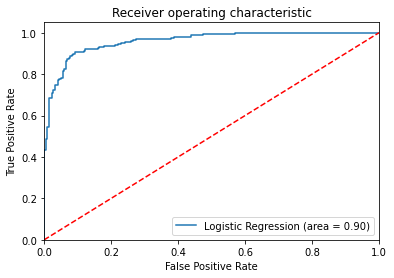

In [37]:
#ROC Curve with Logistic Regression 
logit_roc_auc = roc_auc_score(y_test, logistic.predict(tfidf_test))
fpr, tpr, thresholds = roc_curve(y_test, logistic.predict_proba(tfidf_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [38]:
#Decision Tree
tree = DecisionTreeClassifier()
tree.fit(tfidf_train, y_train)
tree_pred = tree.predict(tfidf_test)
tree.score(tfidf_test, y_test)
print(classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       219
           1       0.81      0.84      0.82       209

    accuracy                           0.82       428
   macro avg       0.82      0.83      0.82       428
weighted avg       0.83      0.82      0.82       428



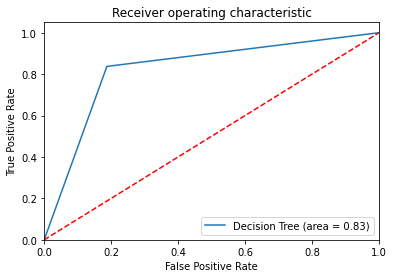

In [39]:
#ROC Curve with Decision Tree
tree_roc_auc = roc_auc_score(y_test, tree.predict(tfidf_test))
fpr, tpr, thresholds = roc_curve(y_test, tree.predict_proba(tfidf_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('tree_ROC')
plt.show()

In [40]:
#Gradient Boosting Classifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(tfidf_train, y_train)
clf_pred = clf.predict(tfidf_test)
clf.score(tfidf_test, y_test)
print(classification_report(y_test, clf_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       219
           1       0.88      0.88      0.88       209

    accuracy                           0.88       428
   macro avg       0.88      0.88      0.88       428
weighted avg       0.88      0.88      0.88       428



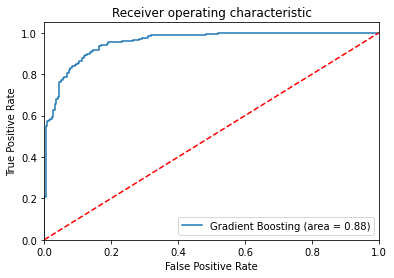

In [41]:
#ROC Curve with Gradient Boosting Model 
clf_roc_auc = roc_auc_score(y_test, clf.predict(tfidf_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(tfidf_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting (area = %0.2f)' % clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('clf_ROC')
plt.show()

In [42]:
#Random Forest Classifier
forest = RandomForestClassifier(random_state=0)
forest.fit(tfidf_train, y_train)
forest_pred = forest.predict(tfidf_test)
forest.score(tfidf_test, y_test)
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       219
           1       0.90      0.87      0.88       209

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428



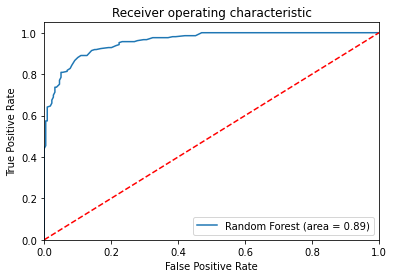

In [43]:
#ROC Curve with Random Forest Classifier
forest_roc_auc = roc_auc_score(y_test, forest.predict(tfidf_test))
fpr, tpr, thresholds = roc_curve(y_test, forest.predict_proba(tfidf_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('forest_ROC')
plt.show()

In [44]:
#Support Vector Machine
svm = SVC()
svm.fit(tfidf_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(tfidf_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(tfidf_test, y_test)))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 0.91


In [45]:
#K-Neartest Neighbors
knn = KNeighborsClassifier()
knn.fit(tfidf_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(tfidf_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(tfidf_test, y_test)))

Accuracy of K-NN classifier on training set: 0.91
Accuracy of K-NN classifier on test set: 0.86


In [46]:
pred = knn.predict(tfidf_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[172  47]
 [ 15 194]]
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       219
           1       0.80      0.93      0.86       209

    accuracy                           0.86       428
   macro avg       0.86      0.86      0.85       428
weighted avg       0.86      0.86      0.85       428



In [47]:
# elapsed time performance with decision tree model
tree = DecisionTreeClassifier()
current_time_tree = time.time()
tree.fit(tfidf_train, y_train)
elapsed_time_tree = time.time() - current_time_tree
print (elapsed_time_tree)

0.09886693954467773


In [48]:
# elapsed time performance with logistic regression
logistic = LogisticRegression()
current_time_lr = time.time()
logistic.fit(tfidf_train,y_train)
elapsed_time_lr = time.time() - current_time_lr
print(elapsed_time_lr)

0.029495954513549805


In [49]:
# elapsed time performance with Gradient Boosting Classifier
clf = GradientBoostingClassifier(random_state=0)
current_time_gb = time.time()
clf.fit(tfidf_train, y_train)
elapsed_time_gb = time.time() - current_time_gb
print(elapsed_time_gb)

0.9350059032440186


In [50]:
# elapsed time performane with Random Forest Classifier
forest = RandomForestClassifier(random_state=0)
current_time_rf = time.time()
forest.fit(tfidf_train, y_train)
elapsed_time_rf = time.time() - current_time_rf
print(elapsed_time_rf)

0.40900206565856934


In [51]:
# elapsed time performance with Support Vector Machine
svm = SVC()
current_time_svm = time.time() 
svm.fit(tfidf_train, y_train)
elapsed_time_svm = time.time() - current_time_svm
print(elapsed_time_svm)

0.5398881435394287


In [52]:
#K-Neartest Neighbors
knn = KNeighborsClassifier()
current_time_knn = time.time()
knn.fit(tfidf_train, y_train)
elapsed_time_knn = time.time() - current_time_knn
print(elapsed_time_knn)

0.0010800361633300781


([<matplotlib.axis.XTick at 0x7fa58ab0c7c0>,
 [Text(0, 0, 'DT'),
  Text(0, 0, 'Logistic'),
  Text(0, 0, 'GB'),
  Text(0, 0, 'RF'),
  Text(0, 0, 'SVN'),
  Text(0, 0, 'KNN')])

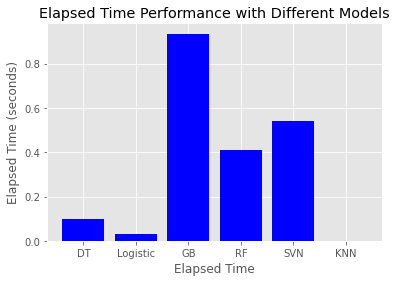

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['DT', 'Logistic', 'GB', 'RF', 'SVN', 'KNN']
Elapsed_Time = [elapsed_time_tree, elapsed_time_lr, elapsed_time_gb, elapsed_time_rf, elapsed_time_svm, elapsed_time_knn]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, Elapsed_Time, color='blue')
plt.xlabel("Elapsed Time")
plt.ylabel("Elapsed Time (seconds)")
plt.title("Elapsed Time Performance with Different Models")

plt.xticks(x_pos, x)


([<matplotlib.axis.XTick at 0x7fa59171c8b0>,
 [Text(0, 0, 'DT'),
  Text(0, 0, 'Logistic'),
  Text(0, 0, 'GB'),
  Text(0, 0, 'RF'),
  Text(0, 0, 'KNN')])

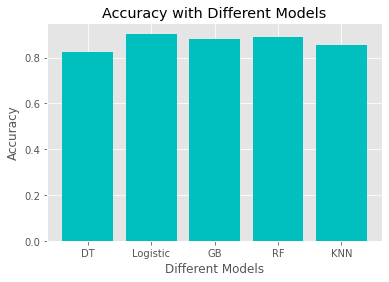

In [54]:
#Box Plot to compare accuracy of three models
lg_acc=accuracy_score(y_test, logistic_pred)
tree_acc=accuracy_score(y_test, tree_pred)
gb_acc=accuracy_score(y_test, clf_pred)
rf_acc=accuracy_score(y_test, forest_pred)
knn_acc=accuracy_score(y_test, pred)

plt.style.use('ggplot')

x = ['DT', 'Logistic', 'GB', 'RF', 'KNN']
Accuracy = [tree_acc, lg_acc, gb_acc, rf_acc, knn_acc]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, Accuracy, color='c')
plt.xlabel("Different Models")
plt.ylabel("Accuracy")
plt.title("Accuracy with Different Models")

plt.xticks(x_pos, x)
